In [1]:
import ROOT
import uproot
import math
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import gamma as gamma_dist
from scipy.stats import lognorm as log_normal_dist
from scipy.stats import norm as gaussian_dist
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import pandas as pd
import os
import gc
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')
fig_size = (8, 6)
# 🔧 解码函数：根据 bitfield <id>calolayer:7,abslayer:1,cellid:13</id>
def decode_volid(volid):
    volid = int(volid)
    calolayer = volid & 0x7F                 # bits 0–6
    abslayer  = (volid >> 7) & 0x1           # bit 7
    cellid    = (volid >> 8) & 0x1FFF        # bits 8–20
    return calolayer, abslayer, cellid

# 🧮 从 cellid 解出 index_x/y/z（若 cellid = z*1600 + y*40 + x）
def decode_indices(cellid):
    index_z = cellid // 1600
    index_y = (cellid % 1600) // 40
    index_x = cellid % 40
    return index_x, index_y, index_z
def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

In [2]:
# 打开 ROOT 文件，载入 events tree
Threshold=0.5*0.1328
#MIP=(0.0410,0.0861,0.1328,0.1803,0.2282)# for Si 0.15mm,0.3mm,0.45mm,0.6mm,0.75mm. Unit is MeV
ECAL_layers=30
def ReadData_Energy(DataPath,ParticleEnergy,precision=0.01):
    E_layers_all = np.empty((0, ECAL_layers))
    N_layers_all = np.empty((0, ECAL_layers))
    E_truth_all  = np.empty((0,))
    for i_E in range(len(ParticleEnergy)):
    #for i_E in range(0,1):
        input_file_name = f"{DataPath}/{ParticleEnergy[i_E]}GeV.root"
        E_layers,N_layers,E_truth = ReadRoot(input_file_name)
        E_layers_all = np.vstack((E_layers_all, np.vstack(E_layers)))
        N_layers_all = np.vstack((N_layers_all, np.vstack(N_layers)))
        E_truth_all  = np.concatenate((E_truth_all, E_truth))
        E_truth_all = np.round(E_truth_all/precision)*precision
    return E_layers_all, N_layers_all, E_truth_all
def ReadData_Uniform(DataPath):
    root_files = [os.path.join(DataPath, f) for f in os.listdir(DataPath) if f.endswith(".root")]
    if len(root_files) == 0:
        raise FileNotFoundError(f"No .root files found in {DataPath}")
    E_layers_all = np.empty((0, ECAL_layers))
    N_layers_all = np.empty((0, ECAL_layers))
    E_truth_all  = np.empty((0,))
    for input_file in root_files:
        E_layers, N_layers, E_truth = ReadRoot(input_file)
        E_layers_all = np.vstack((E_layers_all, E_layers))
        N_layers_all = np.vstack((N_layers_all, N_layers))
        E_truth_all  = np.concatenate((E_truth_all, E_truth))
    return E_layers_all, N_layers_all, E_truth_all
def ReadRoot(input_file_name):
    print(f"Processing file: {input_file_name}")
    input_file = uproot.open(input_file_name)
    tree = input_file["events"]
    cellID = tree["simplecaloRO.cellID"].array(library="ak")
    energy = tree["simplecaloRO.energy"].array(library="ak")
    pos_x  = tree["simplecaloRO.position.x"].array(library="ak")
    pos_y  = tree["simplecaloRO.position.y"].array(library="ak")
    pos_z  = tree["simplecaloRO.position.z"].array(library="ak")
    E_truth = tree["MCParticles.p0"].array(library="ak")
    threshold_mask = energy * 1000 > Threshold
    cellID = cellID[threshold_mask]
    energy = energy[threshold_mask]
    pos_x = pos_x[threshold_mask]
    pos_y = pos_y[threshold_mask]
    pos_z = pos_z[threshold_mask]
    calo_layer = cellID & 0x7F
    num_events = len(energy)
    E_layers = []
    N_layers = []
    for i_event in range(num_events):
        # convert to numpy arrays
        layers = calo_layer[i_event].to_numpy()
        energies = energy[i_event].to_numpy()
        E_layers_event = np.bincount(layers, weights=energies, minlength=ECAL_layers)
        N_layers_event = np.bincount(layers, minlength=ECAL_layers)
        E_layers.append(E_layers_event)
        N_layers.append(N_layers_event)
    E_truth_flat = ak.to_numpy(ak.flatten(E_truth, axis=None))
    return E_layers,N_layers,E_truth_flat
#Read Data
DataPath_Validate="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60"
DataPath_Train="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60"
DataPath_Uniform="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/Uniform"
Energy_Train=(0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,15.0,25.0,35.0,45.0,55.0,65.0)
Energy_test=(0.1,0.25,0.5,1.0,2.0,5.0,10.0,20.0,30.0,40.0,50.0,60.0)#add 0.1 0.25 after all data is ready
#E_layers_train, N_layers_train, E_truth_train = ReadData_Energy(DataPath_Train,Energy_Train)
E_layers_test, N_layers_test, E_truth_test = ReadData_Energy(DataPath_Validate,Energy_test)
E_layers_uniform, N_layers_uniform, E_truth_uniform = ReadData_Uniform(DataPath_Uniform)

Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/0.1GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/0.25GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/0.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/1.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/2.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/5.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_la

length after zero suppression: 1249703 1249703 1249703 1249703 1249703
length after zero suppression: 59990 59990 59990 59990 59990


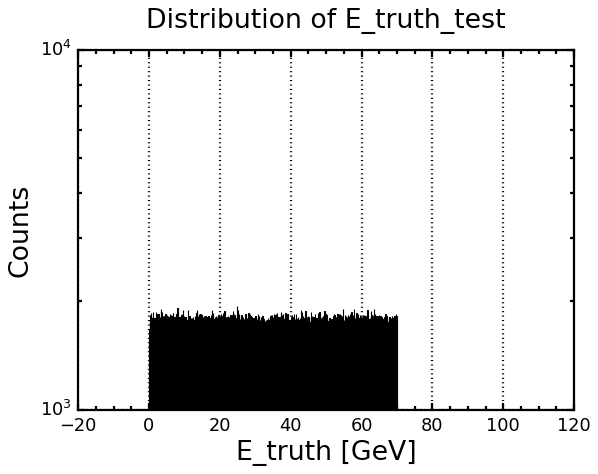

In [3]:
#zero suppression
def zero_suppression(E_layers, N_layers,E_truth):
    N_sum = np.array([np.sum(n) for n in N_layers])
    E_sum = np.array([np.sum(e) for e in E_layers])
    E_truth = np.array(E_truth)

    mask = N_sum > 0
    E_layers_filtered = [E_layers[i] for i in range(len(E_layers)) if mask[i]]
    N_layers_filtered = [N_layers[i] for i in range(len(N_layers)) if mask[i]]    
    E_truth_filtered = E_truth[mask]
    E_sum_filtered = E_sum[mask]
    N_sum_filtered = N_sum[mask]

    print("length after zero suppression:", len(E_layers_filtered), len(N_layers_filtered), len(E_sum_filtered), len(N_sum_filtered), len(E_truth_filtered))
    return E_layers_filtered, N_layers_filtered, E_sum_filtered, N_sum_filtered, E_truth_filtered

#Start from shower layer
def start_from_shower_layer(arr):
    N = len(arr)
    nonzero_idx = np.argmax(arr != 0)
    trimmed = arr[nonzero_idx:]
    if len(trimmed) < N:
        trimmed = np.pad(trimmed, (0, N - len(trimmed)), 'constant')
    return trimmed

def Event_Selection(E_layers,N_layers,E_truth):
    E_layers, N_layers, E_sum, N_sum, E_truth = zero_suppression(E_layers, N_layers, E_truth)
    E_layers = np.array([start_from_shower_layer(ev) for ev in E_layers])
    N_layers = np.array([start_from_shower_layer(ev) for ev in N_layers])
    return E_layers, N_layers, E_sum, N_sum, E_truth

#E_layers_train, N_layers_train, E_sum_train, N_sum_train, E_truth_train = Event_Selection(E_layers_train, N_layers_train, E_truth_train)
E_layers_uniform, N_layers_uniform, E_sum_uniform, N_sum_uniform, E_truth_uniform = Event_Selection(E_layers_uniform, N_layers_uniform, E_truth_uniform)
E_layers_test, N_layers_test, E_sum_test, N_sum_test, E_truth_test = Event_Selection(E_layers_test, N_layers_test, E_truth_test)
#Draw E_truth
plt.figure(figsize=fig_size)
plt.hist(E_truth_uniform, bins=1000, range=(0, 100), edgecolor="black")
#plt.hist(E_truth_test, bins=20, range=(0, 1), edgecolor="black")
plt.xlabel("E_truth [GeV]")
plt.ylabel("Counts")
plt.yscale("log")
plt.title("Distribution of E_truth_test")
plt.grid(True)
plt.show()

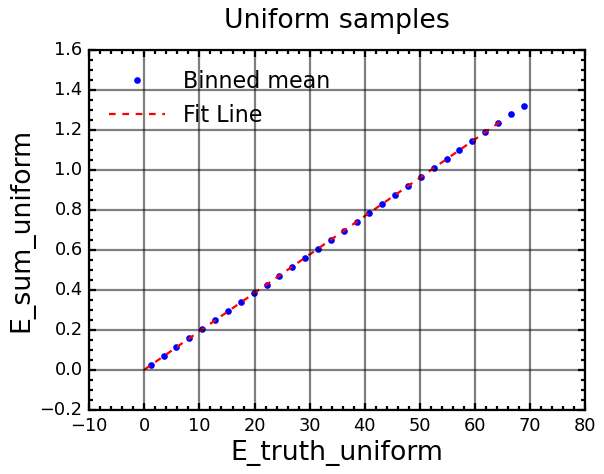

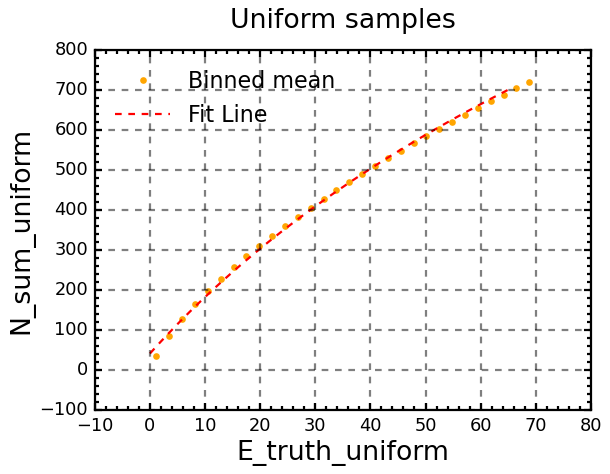

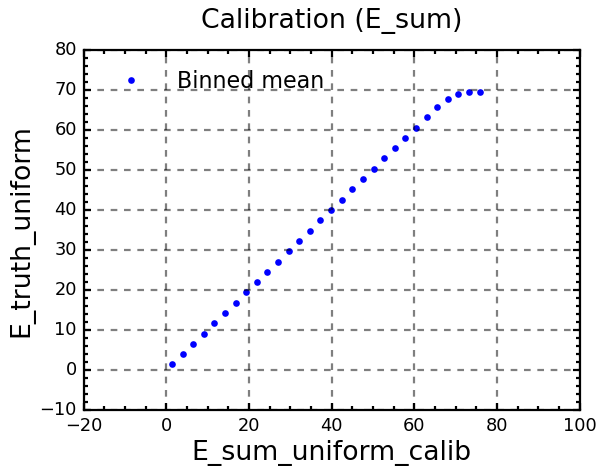

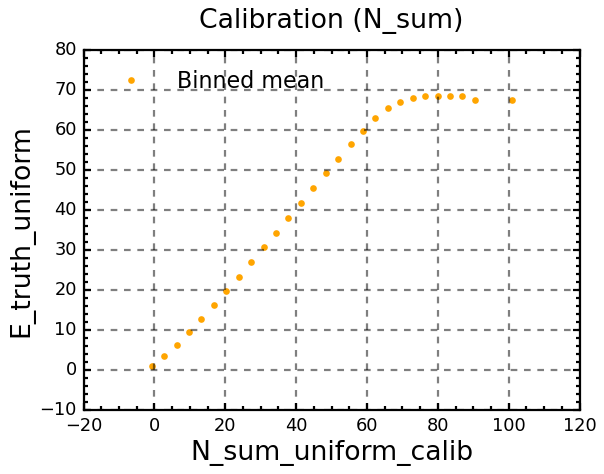

In [4]:
def plot_binned(x, y, num_bins=30, color="blue", label=None):
    """Plot mean y in bins of x."""
    bin_means, bin_edges, _ = binned_statistic(x, y, statistic='mean', bins=num_bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    plt.plot(bin_centers, bin_means, marker="o", linestyle="None", color=color, label=label)

def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

fit_range = (0, 65)
mask_fit = (E_truth_uniform > fit_range[0]) & (E_truth_uniform < fit_range[1])
# E_sum: linear
coeffs_calibE = np.polyfit(E_sum_uniform[mask_fit], E_truth_uniform[mask_fit], 1)
coeffs_calibE_inv = np.polyfit(E_truth_uniform[mask_fit], E_sum_uniform[mask_fit], 1)
E_fit_line = np.poly1d(coeffs_calibE_inv)
# N_sum: exponential
coeffs_calibN, _ = curve_fit(exp_func, N_sum_uniform[mask_fit], E_truth_uniform[mask_fit], p0=(1,0.01,1))
E_fit = exp_func(N_sum_uniform, *coeffs_calibN)
interp_inv = interp1d(E_fit, N_sum_uniform, bounds_error=False, fill_value="extrapolate")

plt.figure(figsize=fig_size)
plot_binned(E_truth_uniform, E_sum_uniform, color="blue", label="Binned mean")
X_line=np.linspace(fit_range[0], fit_range[1], 200)
plt.plot(X_line, E_fit_line(X_line), color="red", linestyle="--", label="Fit Line")
plt.ylabel("E_sum_uniform")
plt.xlabel("E_truth_uniform")
plt.title("Uniform samples")
plt.grid(True, linestyle="-", alpha=0.5)
plt.legend(loc="upper left")

plt.figure(figsize=fig_size)
plot_binned(E_truth_uniform, N_sum_uniform, color="orange", label="Binned mean")
E_vals = np.linspace(fit_range[0], fit_range[1], 200)
N_vals = interp_inv(E_vals)
plt.plot(E_vals, N_vals, color="red", linestyle="--", label="Fit Line")
plt.ylabel("N_sum_uniform")
plt.xlabel("E_truth_uniform")
plt.title("Uniform samples")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left")

E_calib = np.poly1d(coeffs_calibE)
E_sum_uniform_calib = E_calib(E_sum_uniform)
#E_sum_train_calib   = E_calib(E_sum_train)
E_sum_test_calib    = E_calib(E_sum_test)
N_sum_uniform_calib = exp_func(N_sum_uniform, *coeffs_calibN)
#N_sum_train_calib   = exp_func(N_sum_train, *coeffs_calibN)
N_sum_test_calib    = exp_func(N_sum_test, *coeffs_calibN)

plt.figure(figsize=fig_size)
plot_binned(E_sum_uniform_calib,E_truth_uniform, color="blue", label="Binned mean")
plt.xlabel("E_sum_uniform_calib")
plt.ylabel("E_truth_uniform")
plt.title("Calibration (E_sum)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left")

plt.figure(figsize=fig_size)
plot_binned(N_sum_uniform_calib, E_truth_uniform, color="orange", label="Binned mean")
plt.xlabel("N_sum_uniform_calib")
plt.ylabel("E_truth_uniform")
plt.title("Calibration (N_sum)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left")
plt.show()

In [5]:
class RelativeMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps
    def forward(self, y_pred, y_true):
        rel = (y_pred - y_true) / (y_true + self.eps)
        return torch.mean(rel**2)
class RelativeMSELoss_Power3(nn.Module):
    def __init__(self, eps=1e-8, power=3):
        super().__init__()
        self.eps = eps
        self.power = power
    def forward(self, y_pred, y_true):
        out = ((y_pred - y_true)**2) / ((y_true + self.eps)**self.power)
        return torch.mean(out)   
class HuberRelativeLoss(nn.Module):
    def __init__(self, delta=0.1, eps=1e-8):
        super().__init__()
        self.delta = delta
        self.eps = eps
    def forward(self, y_pred, y_true):
        rel = (y_pred - y_true) / (y_true + self.eps)
        denom = torch.clamp(y_true + self.eps, min=1e-6)
        ratio = y_pred / denom
        ratio = torch.clamp(ratio, min=-0.99)  # 保证 log1p 有效
        log = torch.log1p(ratio)
        square = torch.square(ratio)
        abs_log = torch.abs(log)
        abs_rel = torch.abs(rel)
        #Basic
        loss = torch.where(abs_rel < self.delta, 0.5 * rel**2, self.delta * (abs_rel - 0.5*self.delta))
        #Test
        #loss = torch.where(square < 0.01, 0.5 * rel**3, self.delta * (abs_rel - 0.5*self.delta))
        return torch.mean(loss)
class ResidualLinearBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.1, activation=None):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.activation = activation if activation is not None else nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.activation(x)
        out = self.linear(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = out + identity
        return out

class MLPRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], dropout=0.1, activation=nn.PReLU()):
        super().__init__()
        print(f"Hidden dims: {hidden_dims}, Dropout: {dropout}, Activation: {activation}")
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(ResidualLinearBlock(prev_dim, h, dropout=dropout, activation=activation))
            prev_dim = h
        self.model = nn.Sequential(*layers)
        self.output_layer = nn.Linear(prev_dim, 1)

    def forward(self, x):
        x = self.model(x)
        return self.output_layer(x).squeeze(-1)

# ==== Training function ====
def train_mlp(X_train,y_train,
            activation=nn.Sigmoid(),
            loss=HuberRelativeLoss(),
              hidden_dims=[128, 64, 32], 
              dropout=0.1, 
              lr=1e-3,
              weight_decay=5e-5, 
              batch_size=4096, 
              epochs=500,
              patience=10,
              val_split=0.2,
              random_state=42):
    
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    torch.cuda.manual_seed_all(random_state)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    val_split = 0.2
    X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=val_split, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_validate_scaled = scaler.transform(X_validate)

    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_validate_tensor = torch.tensor(X_validate_scaled, dtype=torch.float32)
    y_validate_tensor = torch.tensor(y_validate, dtype=torch.float32)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset   = TensorDataset(X_validate_tensor, y_validate_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    print(f"Random state: {random_state}")
    print(f"Training samples: {len(X_train)}, Validation samples: {int(len(X_validate))}")
    print(f"learning rate: {lr}, batch size: {batch_size}, epochs: {epochs}, patience: {patience}")
    print(f"Loss function: {loss}")

    # Model
    model = MLPRegressor(input_dim=X_train.shape[1], hidden_dims=hidden_dims, dropout=dropout,
                         activation=activation).to(device)

    # Optimizer & Loss
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = loss

    warmup_epochs = 5
    base_lr = lr
    min_lr = 1e-5

    def lr_lambda(current_epoch):
        if current_epoch < warmup_epochs:
            return float(current_epoch + 1) / warmup_epochs
        else:
            progress = (current_epoch - warmup_epochs) / (epochs - warmup_epochs)
        return 0.5 * (1 + math.cos(math.pi * progress))  # 范围 0~1
    scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
    # === Training loop with best model tracking ===
    best_val_loss = float("inf")
    best_state_dict = None
    train_loss_history, val_loss_history, beta_history = [],  [], []
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        scheduler.step()
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                loss = criterion(pred, yb)
                val_loss += loss.item() * xb.size(0)

        train_loss /= len(train_dataset)
        val_loss   /= len(val_dataset)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        print(f"Epoch {epoch+1:03d}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}| LR: {scheduler.get_last_lr()[0]:.6f}")

        # Nan stopping
        if np.isnan(train_loss) or np.isnan(val_loss):
            print("NaN encountered. Stopping training.")
            break
        # Early stopping based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state_dict = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    # Restore best model
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
    
    plt.figure(figsize=fig_size)
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(val_loss_history, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    y_validate_pred = model(X_validate_tensor.to(device)).cpu().detach().numpy()
    return model,scaler,y_validate, y_validate_pred

In [6]:
E_layers_uniform_ratio = E_layers_uniform / (E_sum_uniform[:, np.newaxis])
N_layers_uniform_ratio = N_layers_uniform / (N_sum_uniform[:, np.newaxis])
E_layers_test_ratio    = E_layers_test / (E_sum_test[:, np.newaxis])
N_layers_test_ratio    = N_layers_test / (N_sum_test[:, np.newaxis])
#performance not good
# E_layers_uniform_exp = np.exp(E_layers_uniform_ratio)
# N_layers_uniform_exp = np.exp(N_layers_uniform_ratio)
# E_layers_test_exp    = np.exp(E_layers_test_ratio)
# N_layers_test_exp    = np.exp(N_layers_test_ratio)

E_N_layers_uniform =  E_layers_uniform/(N_layers_uniform+1e-6)
E_N_layers_test    =  E_layers_test/(N_layers_test+1e-6)
#EN_layers_uniform = E_N_layers_uniform * N_layers_uniform
#EN_layers_test    = E_N_layers_test * N_layers_test

LayerNum_uniform = np.array([np.sum(e>0) for e in E_layers_uniform])
LayerNum_test    = np.array([np.sum(e>0) for e in E_layers_test])
Average_E_layer_uniform = E_sum_uniform / (LayerNum_uniform + 1e-6) 
Average_E_layer_test    = E_sum_test / (LayerNum_test + 1e-6)
Average_N_layer_uniform = N_sum_uniform / (LayerNum_uniform + 1e-6)
Average_N_layer_test    = N_sum_test / (LayerNum_test + 1e-6)

In [25]:
X_train = np.hstack([
    E_layers_uniform, 
    E_layers_uniform_ratio,
    E_sum_uniform_calib[:, np.newaxis],
    N_layers_uniform, 
    N_layers_uniform_ratio,
    N_sum_uniform_calib[:, np.newaxis],
    E_N_layers_uniform,
    LayerNum_uniform[:, np.newaxis],
    Average_E_layer_uniform[:, np.newaxis],
    Average_N_layer_uniform[:, np.newaxis],
])
X_test = np.hstack(
    [E_layers_test, 
    E_layers_test_ratio,
    E_sum_test_calib[:,np.newaxis], 
    N_layers_test, 
    N_layers_test_ratio,
    N_sum_test_calib[:,np.newaxis],
    E_N_layers_test,
    LayerNum_test[:, np.newaxis],
    Average_E_layer_test[:, np.newaxis],
    Average_N_layer_test[:, np.newaxis],
])
y_train = E_truth_uniform
y_test = E_truth_test

def plot_features_in_batches(X, feature_names=None, bins=50, n_cols=2, figsize=(12, 6)):
    n_features = X.shape[1]
    n_rows = (n_cols + n_cols - 1) // n_cols  # 每页只有 1 行 2 列的话 n_rows=1
    for start in range(0, n_features, n_cols):
        end = min(start + n_cols, n_features)
        plt.figure(figsize=figsize)
        for i, j in enumerate(range(start, end)):
            plt.subplot(1, n_cols, i + 1)
            plt.hist(X[:, j], bins=bins, color='skyblue', edgecolor='black')
            plt.yscale('log')
            if feature_names:
                plt.title(feature_names[j], fontsize=10)
            else:
                plt.title(f"Feature {j}", fontsize=10)
        plt.subplots_adjust(hspace=0.4, wspace=0.3)
        plt.show()
#plot_features_in_batches(X_train, bins=50, n_cols=2, figsize=(12, 6))

Using device: cuda
Random state: 42
Training samples: 999762, Validation samples: 249941
learning rate: 0.001, batch size: 4096, epochs: 50, patience: 10
Loss function: HuberRelativeLoss()
Hidden dims: [128, 64, 32], Dropout: 0.1, Activation: PReLU(num_parameters=1)
Epoch 001/50 | Train Loss: 0.063521 | Val Loss: 0.013738| LR: 0.000400
Epoch 002/50 | Train Loss: 0.010604 | Val Loss: 0.006842| LR: 0.000600
Epoch 003/50 | Train Loss: 0.007379 | Val Loss: 0.003691| LR: 0.000800
Epoch 004/50 | Train Loss: 0.006101 | Val Loss: 0.002806| LR: 0.001000
Epoch 005/50 | Train Loss: 0.005249 | Val Loss: 0.002970| LR: 0.001000
Epoch 006/50 | Train Loss: 0.004461 | Val Loss: 0.002206| LR: 0.000999
Epoch 007/50 | Train Loss: 0.003954 | Val Loss: 0.002726| LR: 0.000995
Epoch 008/50 | Train Loss: 0.003825 | Val Loss: 0.003412| LR: 0.000989
Epoch 009/50 | Train Loss: 0.003138 | Val Loss: 0.002324| LR: 0.000981
Epoch 010/50 | Train Loss: 0.002977 | Val Loss: 0.001769| LR: 0.000970
Epoch 011/50 | Train Lo

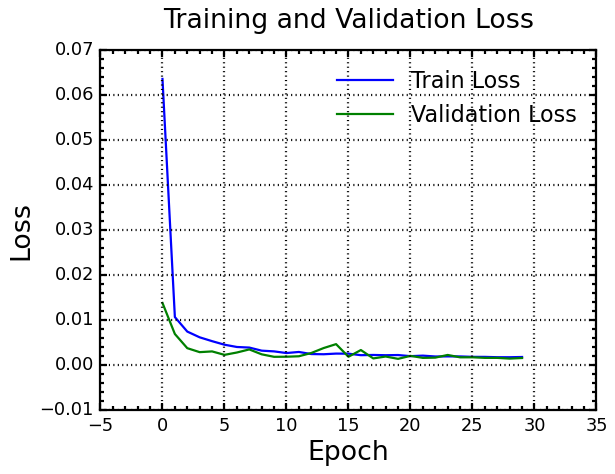

In [26]:
ParameterScan=[1e-3,]#not used, but the loop is kept for future parameter scanning
Reco_hist_mlp_all = []
for lr in ParameterScan:
  mlp_model,scaler,y_validate, y_validate_pred = train_mlp(X_train, y_train,
                    activation=nn.PReLU(),
                    hidden_dims=[128,64,32],
                      dropout=0.1,
                      loss=HuberRelativeLoss(delta=0.1),
                      lr=lr,
                      weight_decay=5e-5,
                      batch_size=4096,
                      epochs=50,
                      patience=10,
                      random_state=42)
  device = next(mlp_model.parameters()).device
  torch.save(mlp_model, DataPath_Validate+f"/Models/MLP.pth")


In [27]:
def Combined_fit(x, y, fit_range=(0,65), plot=True, num_bins=100):
    #Step 1: Linear
    linear_range = (10,60)
    mask_lin = (x > linear_range[0]) & (x < linear_range[1])
    coeffs_lin = np.polyfit(x[mask_lin], y[mask_lin], 1)
    y_lin = np.poly1d(coeffs_lin)(x)
    residual = y - y_lin
    print("Step 1 Linear fit coeffs:", coeffs_lin)
    
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, y, num_bins=num_bins, color="blue", label="Data (bin mean)")
        plt.plot(x[mask_lin], y_lin[mask_lin], color="red", linestyle="--", label="Step1: Linear")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Step 1: Linear Fit")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()
    
    # Step 2: exp fit
    #residual = y
    fit_range = (2, 10)
    mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    def fit_func2(x, a, b, c):
        return a * np.exp(b * x) + c
    coeff_fit2, _ = curve_fit(fit_func2, x[mask_fit], residual[mask_fit], p0=(1, -0.1, 0))
    x_fit2 = np.linspace(fit_range[0], fit_range[1], 200)
    y_fit2 = fit_func2(x_fit2, *coeff_fit2)
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual (bin mean)")
        plt.plot(x_fit2, y_fit2, color="red", linestyle="-", label="Step2: exp Fit")
        plt.xlabel("x")
        plt.ylabel("Residual")
        plt.title("Step 2: exp Fit Residual")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()

    residual = y - fit_func2(x, *coeff_fit2)

    # Step 3: exp fit
    # if plot:
    #     plt.figure(figsize=(5,4))
    #     plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual (bin mean)")
    #     plt.xlabel("x")
    #     plt.ylabel("Residual")
    #     plt.title("Step 3: exp Fit Residual")
    #     plt.grid(True, linestyle="--", alpha=0.5)
    #     plt.show()
    # fit_range = (10, 30)
    # mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    # def fit_func3(x, a, b, c):
    #     return a * np.exp(b * x) + c
    # coeff_fit3, _ = curve_fit(fit_func3, x[mask_fit], residual[mask_fit], p0=(1, -0.1, 0))
    # x_fit3 = np.linspace(fit_range[0], fit_range[1], 200)
    # y_fit3 = fit_func3(x_fit3, *coeff_fit3)
    # if plot:
    #     plt.plot(x_fit3, y_fit3, color="red", linestyle="-", label="Step3: exp Fit")

    # residual = y - fit_func2(x, *coeff_fit2) - fit_func3(x, *coeff_fit3)

    # Step 4: Linear again
    mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    params_lin2 = np.polyfit(x[mask_fit], residual[mask_fit], 1)
    y_lin2 = np.poly1d(params_lin2)(x)
    print("Step 3 Linear fit coeffs:", params_lin2)
    
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual after Step2 (bin mean)")
        plt.plot(x, y_lin2, color="red", linestyle="--", label="Step3: Linear Fit")
        plt.xlabel("x")
        plt.ylabel("Residual")
        plt.title("Step 3: Linear Fit Residual")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()
    
    # Final combined function
    def f(x_val):
        return ( 
                fit_func2(x_val, *coeff_fit2) + 
                #fit_func3(x_val, *coeff_fit3) + 
                np.poly1d(params_lin2)(x_val))
    return f
def build_reco_hist(y_pred, y_truth, Energy_test, Nbins=50):
    reco_hist = []
    for i_E, E_truth in enumerate(Energy_test):
        mask = (y_truth == E_truth)
        reco_energy = y_pred[mask]

        if len(reco_energy) == 0:
            print(f"No events found for E_truth = {E_truth} GeV, skipping.")
            continue

        mean = np.mean(reco_energy)
        rms = np.std(reco_energy)
        valid_mask = (reco_energy >= mean - 5*rms) & (reco_energy <= mean + 5*rms)

        filtered_data = reco_energy[valid_mask]
        counts, bin_edges = np.histogram(filtered_data, bins=Nbins)

        reco_hist.append({
            "E_truth": E_truth,
            "counts": counts,
            "bin_edges": bin_edges
        })
    return reco_hist

y_pred=y_validate_pred
y_true=y_validate
X_test_scaled = scaler.transform(X_test)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
with torch.no_grad():
    y_pred_test_mlp = mlp_model(X_test_tensor).detach().cpu().numpy()
Reco_hist_mlp_all.clear()
Reco_hist_mlp = build_reco_hist(y_pred_test_mlp, E_truth_test, Energy_test, Nbins=50)
Reco_hist_mlp_all.append(Reco_hist_mlp)

# fit_range = (0, 65) 
# mask = y_pred>0
# residual_E = (y_pred[mask] - y_true[mask]) / y_pred[mask]
# E_calib_fit = Combined_fit(y_pred[mask], residual_E, fit_range=fit_range, plot=True, num_bins=200)
# x_fit = np.linspace(fit_range[0], fit_range[1], 200)
# y_fit = E_calib_fit(x_fit)
# plt.figure(figsize=fig_size)
# plot_binned(y_pred[mask], residual_E, num_bins=200, color="blue", label="Validate samples")
# #plot_binned(y_pred_test_mlp, (y_pred_test_mlp - y_test) / y_pred_test_mlp,num_bins=200, color="orange", label="Test samples")
# plt.plot(x_fit, y_fit, color='red', label='Fit')
# plt.xlabel("E_pred [GeV]")
# plt.ylabel("(E_pred - E_true)/E_pred")
# plt.title("Residual vs E_pred")
# plt.grid(True, linestyle="--", alpha=0.5)
# plt.legend(loc="lower right")
# plt.show()

# y_pred_calib = y_pred*(1-E_calib_fit(y_pred))
# y_pred_test_mlp_calib = y_pred_test_mlp*(1-E_calib_fit(y_pred_test_mlp))
# Reco_hist_mlp_all.clear()
# Reco_hist_mlp = build_reco_hist(y_pred_test_mlp_calib, E_truth_test, Energy_test, Nbins=50)
# Reco_hist_mlp_all.append(Reco_hist_mlp)

# plt.figure(figsize=fig_size)
# plot_binned(y_test, y_pred_test_mlp, color="blue", label="test samples")
# plot_binned(y_true, y_pred, color="green", label="validate samples")
# plt.xlabel("E_truth [GeV]")
# plt.ylabel("E_pred [GeV]")
# plt.title("MLP Reconstructed Energy vs True Energy")
# plt.grid(True, linestyle="--", alpha=0.5)
# plt.legend(loc="upper left")  
# plt.show()


In [28]:
def fit_gamma(x, norm, k, mu, theta):
    return norm * gamma_dist.pdf(x, k, loc=mu, scale=theta)

def fit_log_normal(x, norm, sigma, loc, scale):
    """Log-normal distribution with location parameter."""
    return norm * log_normal_dist.pdf(x, s=sigma, loc=loc, scale=scale)

def fit_gaussian(x, norm, resolution, mean):
    return norm * gaussian_dist.pdf(x, loc=mean, scale=mean * resolution)

def fit_all(type,E_truth,counts,bin_edges):
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    dx = bin_edges[1] - bin_edges[0]
    peak = bin_centers[np.argmax(counts)]
    mean = np.average(bin_centers, weights=counts)
    rms = np.sqrt(np.average((bin_centers - mean)**2, weights=counts))
    print(f"Mean: {mean}, Peak: {peak}, RMS: {rms}")
    plt.figure(figsize=fig_size)
    plt.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0], alpha=0.6, label="Data", color='blue')

    #Gamma Fit
    #theta = abs(mean - peak)
    #k = rms / np.sqrt(theta)
    #mu = E_truth
    theta = max(rms, 1e-6)
    k = max((mean - bin_edges[0]) / theta, 1e-3)
    mu = bin_edges[0] # or try mean - k*theta
    norm = counts.sum() * dx
    params_gamma_initial = [norm, k, mu, theta]
    lower_bounds = [norm*0.01, k*0.1-1, mu*0.1-1, theta*0.1]
    upper_bounds = [norm*6, k*10, mu*1.5+10, theta*10]
    print(f"Initial Gamma Fit Parameters: {params_gamma_initial}")
    print(f"Gamma Fit Bounds: lower {lower_bounds}, \n upper {upper_bounds}")
    params_gamma, cov_gamma = curve_fit(fit_gamma, bin_centers, counts, p0=params_gamma_initial, bounds=(lower_bounds, upper_bounds))
    print(f"Gamma Fit Parameters: {params_gamma}")
    x_fit_gamma = np.linspace(bin_edges[0], bin_edges[-1], 100)
    y_fit_gamma = fit_gamma(x_fit_gamma, *params_gamma)
    #calculate peak and resolution
    k,mu,theta = params_gamma[1], params_gamma[2], params_gamma[3]
    peak_gamma = (k-1) * theta + mu
    J = np.array([0,theta, 1.0, (k - 1.0)])
    peak_gamma_error = np.sqrt(J @ cov_gamma @ J)
    mean_gamma = k * theta + mu
    J = np.array([0,theta, 1.0, k])
    mean_gamma_error = np.sqrt(J @ cov_gamma @ J)
    #res
    res_gamma = np.sqrt(k) * theta / peak_gamma
    dr_dnorm = 0.0
    dr_dk = (0.5 / np.sqrt(k) * theta * peak_gamma - np.sqrt(k) * theta * (theta)) / (peak_gamma**2)
    dr_dmu = - np.sqrt(k) * theta / (peak_gamma**2)
    dr_dtheta = (np.sqrt(k) * peak_gamma - np.sqrt(k) * theta * (k - 1.0)) / (peak_gamma**2)
    J = np.array([dr_dnorm, dr_dk, dr_dmu, dr_dtheta])
    res_gamma_error = np.sqrt(J @ cov_gamma @ J)
    print(f"Gamma Fit Peak: {peak_gamma} ± {peak_gamma_error}, Mean: {mean_gamma} ± {mean_gamma_error}, Resolution: {res_gamma} ± {res_gamma_error}")
    if type == "E":
        plt.title(f"Deposited Energy {E_truth} GeV")
        plt.xlabel("Deposited Energy [MeV]")
        plt.ylabel("Counts")
    elif type == "N":
        plt.title(f"Number of Hits {E_truth} GeV")
        plt.xlabel("Number of Hits")
        plt.ylabel("Counts")
    elif type == "E_reco":
        plt.title(f"Reconstructed Energy {E_truth} GeV")
        plt.xlabel("Reconstructed Energy [GeV]")
        plt.ylabel("Counts")
    else:
        print("Unknown type")
        return 0
    plt.plot(x_fit_gamma, y_fit_gamma, 'r-', label="Gamma Fit")
    #plt.xlim(peak_gamma - 4*peak_gamma*res_gamma, peak_gamma + 8*peak_gamma*res_gamma)
    #plt.yscale("log")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    return (mean_gamma, mean_gamma_error, peak_gamma, peak_gamma_error, res_gamma, res_gamma_error)


length of Reco_hist_mlp_all: 1
length of Reco_hist_mlp: 12
Mean: 9.928064750092268, Peak: 10.04952621459961, RMS: 0.5983827896930675
Initial Gamma Fit Parameters: [np.float64(595.7214841842651), np.float64(4.8814514990209785), np.float32(7.007088), np.float64(0.5983827896930675)]
Gamma Fit Bounds: lower [np.float64(5.957214841842651), np.float64(-0.5118548500979021), np.float32(-0.2992912), np.float64(0.05983827896930675)], 
 upper [np.float64(3574.328905105591), np.float64(48.81451499020979), np.float32(20.510632), np.float64(5.983827896930674)]
Gamma Fit Parameters: [5.90000038e+02 4.88145150e+01 5.92534209e+00 8.26520965e-02]
Gamma Fit Peak: 9.877311990677313 ± 0.00962081050904779, Mean: 9.959964087128013 ± 0.009701316055488848, Resolution: 0.058464143448071035 ± 0.000673834795107075


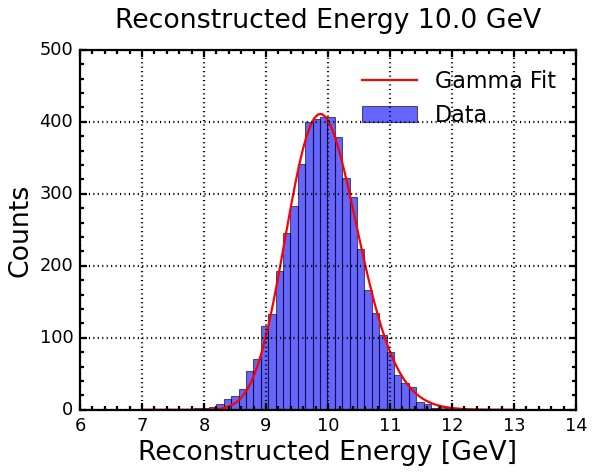

In [29]:
#This cell is left here for debug
print("length of Reco_hist_mlp_all:", len(Reco_hist_mlp_all))
Reco_hist_mlp = Reco_hist_mlp_all[0] # Example for first beta
print("length of Reco_hist_mlp:", len(Reco_hist_mlp))
i_E = 6 # Example index, change as needed
#print(len(Reco_hist_mlp))
#print(Reco_hist_mlp[i_E])
mean_gamma,mean_gamma_error,peak_gamma,peak_gamma_error,res_gamma,res_gamma_error = fit_all(
    "E_reco",Reco_hist_mlp[i_E]["E_truth"],Reco_hist_mlp[i_E]["counts"],Reco_hist_mlp[i_E]["bin_edges"])

Mean: 0.15008545763729292, Peak: 0.13452830910682678, RMS: 0.04402819179000189
Initial Gamma Fit Parameters: [np.float64(50.343346022069454), np.float64(2.9927456692408416), np.float32(0.018320277), np.float64(0.04402819179000189)]
Gamma Fit Bounds: lower [np.float64(0.5034334602206946), np.float64(-0.7007254330759158), np.float32(-0.998168), np.float64(0.004402819179000189)], 
 upper [np.float64(302.0600761324167), np.float64(29.927456692408416), np.float32(10.02748), np.float64(0.4402819179000189)]
Gamma Fit Parameters: [4.94645906e+01 5.22718447e+00 5.63332387e-02 1.78253334e-02]
Gamma Fit Peak: 0.13168421112547768 ± 0.0008091044914487255, Mean: 0.14950954450087328 ± 0.000883850721038284, Resolution: 0.30948376240454634 ± 0.00710401019163917


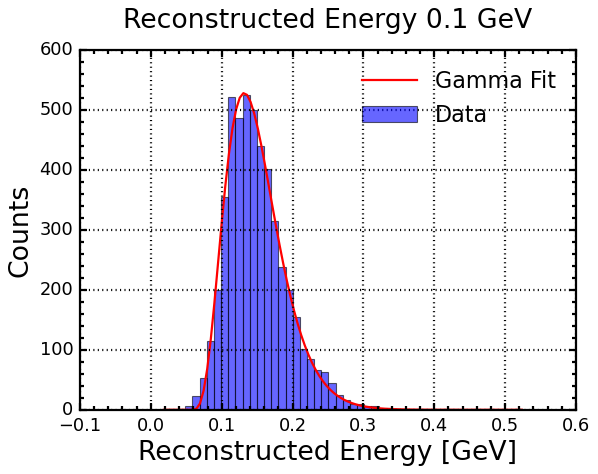

appending results for E = 0.1
Mean_Gamma: 0.14950954450087328 Mean_Gamma_Error: 0.000883850721038284
Peak_Gamma: 0.13168421112547768 Peak_Gamma_Error: 0.0008091044914487255
Mean: 0.29077014673192675, Peak: 0.29370781779289246, RMS: 0.07183739832208118
Initial Gamma Fit Parameters: [np.float64(57.24076688289642), np.float64(3.227336533652127), np.float32(0.058926687), np.float64(0.07183739832208118)]
Gamma Fit Bounds: lower [np.float64(0.5724076688289642), np.float64(-0.6772663466347872), np.float32(-0.9941073), np.float64(0.007183739832208118)], 
 upper [np.float64(343.44460129737854), np.float64(32.27336533652127), np.float32(10.08839), np.float64(0.7183739832208118)]
Gamma Fit Parameters: [ 5.71220549e+01  3.22733653e+01 -1.10824578e-01  1.24427378e-02]
Gamma Fit Peak: 0.2783017064947149 ± 0.0013877123038284216, Mean: 0.2907444442804686 ± 0.0014055366109303625, Resolution: 0.25399326846650866 ± 0.003996131020208364


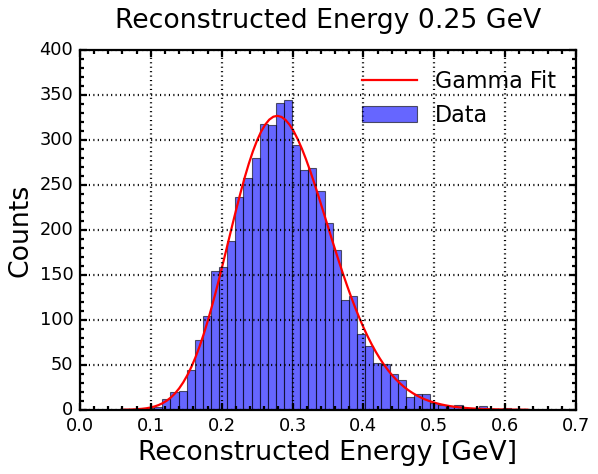

appending results for E = 0.25
Mean_Gamma: 0.2907444442804686 Mean_Gamma_Error: 0.0014055366109303625
Peak_Gamma: 0.2783017064947149 Peak_Gamma_Error: 0.0013877123038284216
Mean: 0.5347423913769539, Peak: 0.48355832695961, RMS: 0.11023650452576063
Initial Gamma Fit Parameters: [np.float64(90.30992476642132), np.float64(4.1530960454431085), np.float32(0.0769196), np.float64(0.11023650452576063)]
Gamma Fit Bounds: lower [np.float64(0.9030992476642132), np.float64(-0.5846903954556891), np.float32(-0.992308), np.float64(0.011023650452576063)], 
 upper [np.float64(541.8595485985279), np.float64(41.53096045443108), np.float32(10.115379), np.float64(1.1023650452576064)]
Gamma Fit Parameters: [ 9.02976374e+01  2.74086494e+01 -4.05681906e-02  2.09580365e-02]
Gamma Fit Peak: 0.5129052470621658 ± 0.0024855007236770444, Mean: 0.5338632835690854 ± 0.0025234246399953816, Resolution: 0.213922895459059 ± 0.003852137682430661


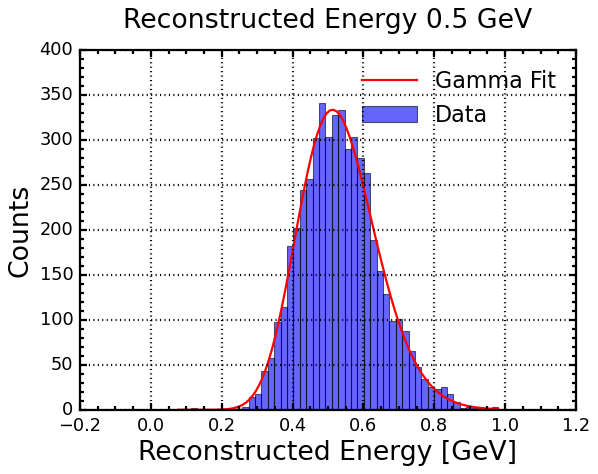

appending results for E = 0.5
Mean_Gamma: 0.5338632835690854 Mean_Gamma_Error: 0.0025234246399953816
Peak_Gamma: 0.5129052470621658 Peak_Gamma_Error: 0.0024855007236770444
Mean: 1.0341509399020117, Peak: 1.0234355926513672, RMS: 0.16170697683926138
Initial Gamma Fit Parameters: [np.float64(151.45654645562172), np.float64(4.656577719933807), np.float32(0.28114983), np.float64(0.16170697683926138)]
Gamma Fit Bounds: lower [np.float64(1.5145654645562172), np.float64(-0.5343422280066192), np.float32(-0.971885), np.float64(0.01617069768392614)], 
 upper [np.float64(908.7392787337303), np.float64(46.56577719933807), np.float32(10.421724), np.float64(1.6170697683926138)]
Gamma Fit Parameters: [ 1.51188464e+02  4.65657772e+01 -5.72065762e-02  2.34831648e-02]
Gamma Fit Peak: 1.0128220809342898 ± 0.003692277789980153, Mean: 1.0363052457765942 ± 0.003724922719973006, Resolution: 0.1582183654871857 ± 0.0026604359488883816


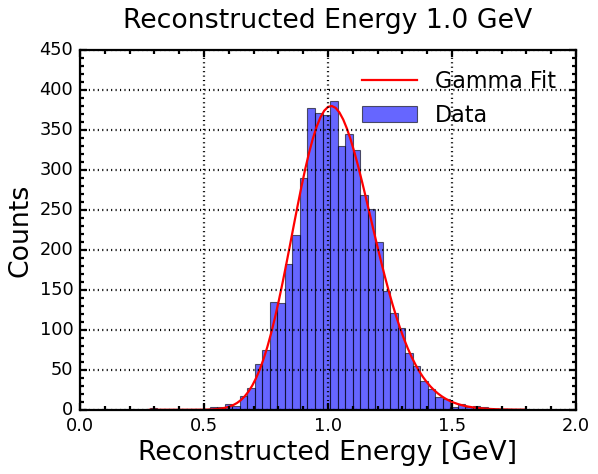

appending results for E = 1.0
Mean_Gamma: 1.0363052457765942 Mean_Gamma_Error: 0.003724922719973006
Peak_Gamma: 1.0128220809342898 Peak_Gamma_Error: 0.003692277789980153
Mean: 2.0036215139351623, Peak: 1.9267950057983398, RMS: 0.2441010047217456
Initial Gamma Fit Parameters: [np.float64(188.77650833129883), np.float64(3.333225726700036), np.float32(1.1899778), np.float64(0.2441010047217456)]
Gamma Fit Bounds: lower [np.float64(1.8877650833129884), np.float64(-0.6666774273299965), np.float32(-0.88100225), np.float64(0.02441010047217456)], 
 upper [np.float64(1132.659049987793), np.float64(33.33225726700036), np.float32(11.784966), np.float64(2.441010047217456)]
Gamma Fit Parameters: [1.88146702e+02 3.31045600e+01 6.14388133e-01 4.20100292e-02]
Gamma Fit Peak: 1.9631016385917315 ± 0.003503560731876801, Mean: 2.005111667819233 ± 0.003547242253527319, Resolution: 0.12312722974739039 ± 0.0013166785061108858


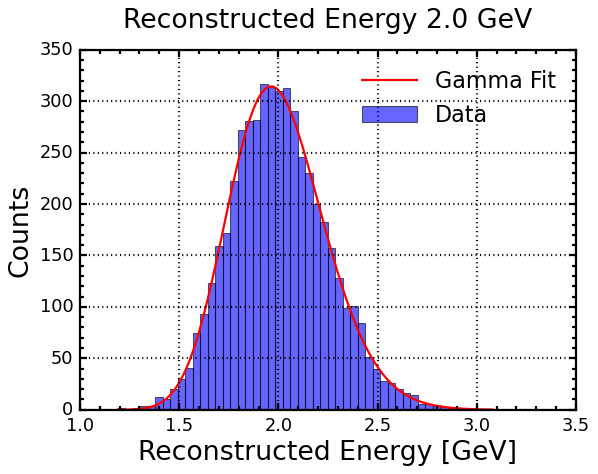

appending results for E = 2.0
Mean_Gamma: 2.005111667819233 Mean_Gamma_Error: 0.003547242253527319
Peak_Gamma: 1.9631016385917315 Peak_Gamma_Error: 0.003503560731876801
Mean: 4.969016491340359, Peak: 4.874502182006836, RMS: 0.40540485293440576
Initial Gamma Fit Parameters: [np.float64(343.6644558906555), np.float64(3.5431615729766404), np.float32(3.5326016), np.float64(0.40540485293440576)]
Gamma Fit Bounds: lower [np.float64(3.436644558906555), np.float64(-0.6456838427023359), np.float32(-0.64673984), np.float64(0.04054048529344058)], 
 upper [np.float64(2061.986735343933), np.float64(35.431615729766406), np.float32(15.2989025), np.float64(4.054048529344057)]
Gamma Fit Parameters: [3.45634008e+02 3.54316157e+01 2.53697158e+00 6.90294964e-02]
Gamma Fit Peak: 4.913768667941146 ± 0.007942823801146512, Mean: 4.982798164295336 ± 0.008035000568630504, Resolution: 0.0836210230539174 ± 0.001160838961961394


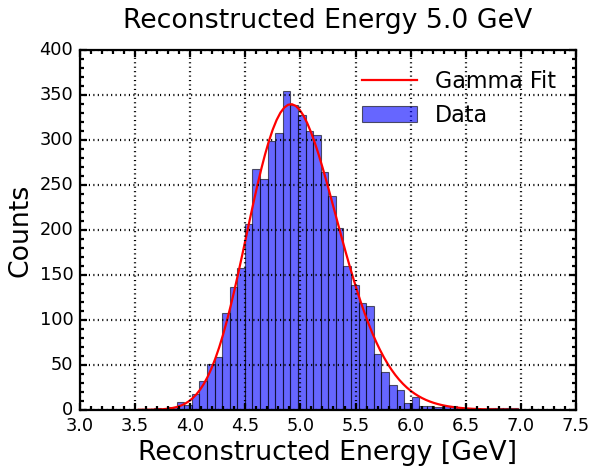

appending results for E = 5.0
Mean_Gamma: 4.982798164295336 Mean_Gamma_Error: 0.008035000568630504
Peak_Gamma: 4.913768667941146 Peak_Gamma_Error: 0.007942823801146512
Mean: 9.928064750092268, Peak: 10.04952621459961, RMS: 0.5983827896930675
Initial Gamma Fit Parameters: [np.float64(595.7214841842651), np.float64(4.8814514990209785), np.float32(7.007088), np.float64(0.5983827896930675)]
Gamma Fit Bounds: lower [np.float64(5.957214841842651), np.float64(-0.5118548500979021), np.float32(-0.2992912), np.float64(0.05983827896930675)], 
 upper [np.float64(3574.328905105591), np.float64(48.81451499020979), np.float32(20.510632), np.float64(5.983827896930674)]
Gamma Fit Parameters: [5.90000038e+02 4.88145150e+01 5.92534209e+00 8.26520965e-02]
Gamma Fit Peak: 9.877311990677313 ± 0.00962081050904779, Mean: 9.959964087128013 ± 0.009701316055488848, Resolution: 0.058464143448071035 ± 0.000673834795107075


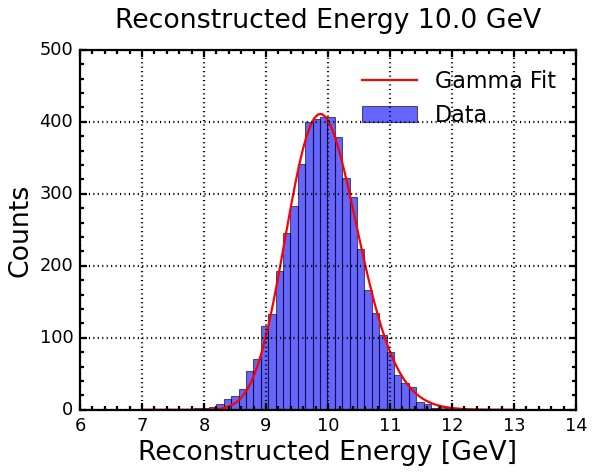

appending results for E = 10.0
Mean_Gamma: 9.959964087128013 Mean_Gamma_Error: 0.009701316055488848
Peak_Gamma: 9.877311990677313 Peak_Gamma_Error: 0.00962081050904779
Mean: 19.96650829257908, Peak: 19.925682067871094, RMS: 0.867614058720814
Initial Gamma Fit Parameters: [np.float64(717.3510074615479), np.float64(3.44038194589628), np.float32(16.981585), np.float64(0.867614058720814)]
Gamma Fit Bounds: lower [np.float64(7.1735100746154785), np.float64(-0.655961805410372), np.float32(0.6981585), np.float64(0.0867614058720814)], 
 upper [np.float64(4304.106044769287), np.float64(34.4038194589628), np.float32(35.472378), np.float64(8.67614058720814)]
Gamma Fit Parameters: [7.15078557e+02 3.44038195e+01 1.49802842e+01 1.46477617e-01]
Gamma Fit Peak: 19.87319606795012 ± 0.022852972090910927, Mean: 20.019673684673705 ± 0.02312613671947443, Resolution: 0.04323215434248193 ± 0.0008129103679486418


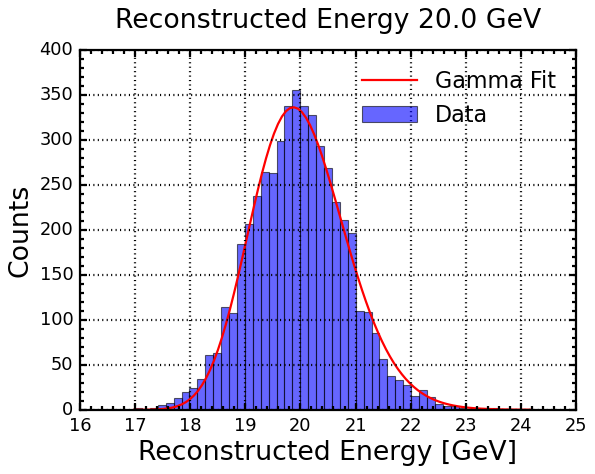

appending results for E = 20.0
Mean_Gamma: 20.019673684673705 Mean_Gamma_Error: 0.02312613671947443
Peak_Gamma: 19.87319606795012 Peak_Gamma_Error: 0.022852972090910927
Mean: 30.014187788185605, Peak: 30.164199829101562, RMS: 1.0924291385750635
Initial Gamma Fit Parameters: [np.float64(1018.9900608062744), np.float64(4.622664510304209), np.float32(24.964254), np.float64(1.0924291385750635)]
Gamma Fit Bounds: lower [np.float64(10.189900608062745), np.float64(-0.5377335489695791), np.float32(1.4964254), np.float64(0.10924291385750635)], 
 upper [np.float64(6113.9403648376465), np.float64(46.22664510304209), np.float32(47.44638), np.float64(10.924291385750635)]
Gamma Fit Parameters: [1.01722904e+03 4.62266451e+01 2.27249404e+01 1.58996779e-01]
Gamma Fit Peak: 29.91583128590423 ± 0.028170468998105103, Mean: 30.074828064951166 ± 0.02841936122412185, Resolution: 0.036135447635893436 ± 0.0006480859704475736


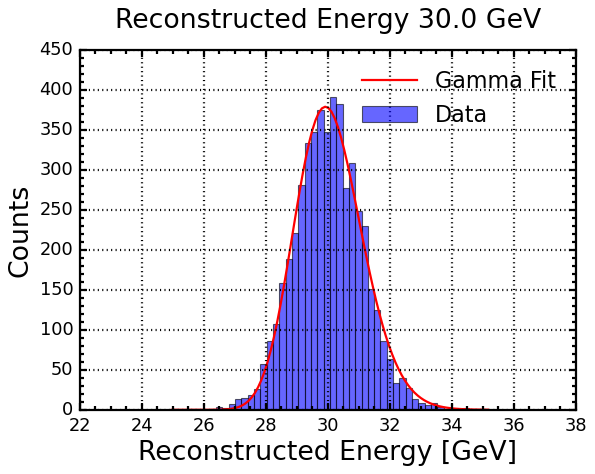

appending results for E = 30.0
Mean_Gamma: 30.074828064951166 Mean_Gamma_Error: 0.02841936122412185
Peak_Gamma: 29.91583128590423 Peak_Gamma_Error: 0.028170468998105103
Mean: 40.155187909619826, Peak: 40.52265548706055, RMS: 1.2513975756317786
Initial Gamma Fit Parameters: [np.float64(1100.5066680908203), np.float64(4.3719721592313165), np.float32(34.684113), np.float64(1.2513975756317786)]
Gamma Fit Bounds: lower [np.float64(11.005066680908204), np.float64(-0.5628027840768683), np.float32(2.4684112), np.float64(0.12513975756317786)], 
 upper [np.float64(6603.040008544922), np.float64(43.719721592313164), np.float32(62.02617), np.float64(12.513975756317786)]
Gamma Fit Parameters: [1.09285844e+03 4.37197216e+01 3.21252191e+01 1.85179068e-01]
Gamma Fit Peak: 40.03601735632971 ± 0.02358905267713125, Mean: 40.22119642400189 ± 0.023809758924400067, Resolution: 0.030582974189602527 ± 0.00040628622873068625


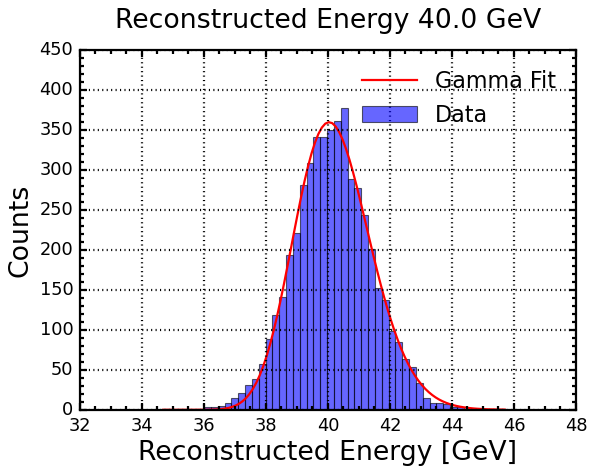

appending results for E = 40.0
Mean_Gamma: 40.22119642400189 Mean_Gamma_Error: 0.023809758924400067
Peak_Gamma: 40.03601735632971 Peak_Gamma_Error: 0.02358905267713125
Mean: 50.40213981745934, Peak: 50.60224914550781, RMS: 1.3535064641837204
Initial Gamma Fit Parameters: [np.float64(1042.0240669250488), np.float64(4.2413214895674765), np.float32(44.661484), np.float64(1.3535064641837204)]
Gamma Fit Bounds: lower [np.float64(10.420240669250488), np.float64(-0.5758678510432523), np.float32(3.4661484), np.float64(0.13535064641837205)], 
 upper [np.float64(6252.144401550293), np.float64(42.41321489567476), np.float32(76.992226), np.float64(13.535064641837204)]
Gamma Fit Parameters: [1.03983568e+03 4.24132149e+01 4.16534437e+01 2.08460694e-01]
Gamma Fit Peak: 50.286471244562776 ± 0.03428544117747438, Mean: 50.49493193894005 ± 0.03466121551913623, Resolution: 0.02699750408868837 ± 0.0004708611754194625


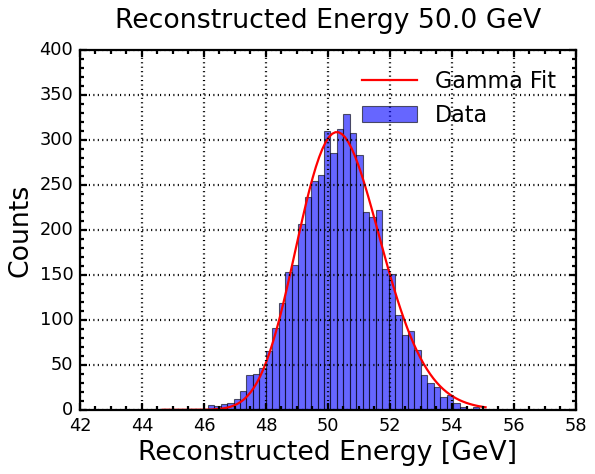

appending results for E = 50.0
Mean_Gamma: 50.49493193894005 Mean_Gamma_Error: 0.03466121551913623
Peak_Gamma: 50.286471244562776 Peak_Gamma_Error: 0.03428544117747438
Mean: 60.24797868289772, Peak: 59.720882415771484, RMS: 1.4501070375892433
Initial Gamma Fit Parameters: [np.float64(1137.6215515136719), np.float64(3.581265774892887), np.float32(55.05476), np.float64(1.4501070375892433)]
Gamma Fit Bounds: lower [np.float64(11.37621551513672), np.float64(-0.6418734225107112), np.float32(4.505476), np.float64(0.14501070375892433)], 
 upper [np.float64(6825.729309082031), np.float64(35.81265774892887), np.float32(92.58214), np.float64(14.501070375892432)]
Gamma Fit Parameters: [1.13376773e+03 3.58126577e+01 5.16783069e+01 2.42427735e-01]
Gamma Fit Peak: 60.11786068647393 ± 0.029850396381689053, Mean: 60.36028842114841 ± 0.030193642057334675, Resolution: 0.02413220810348855 ± 0.00034703584553010246


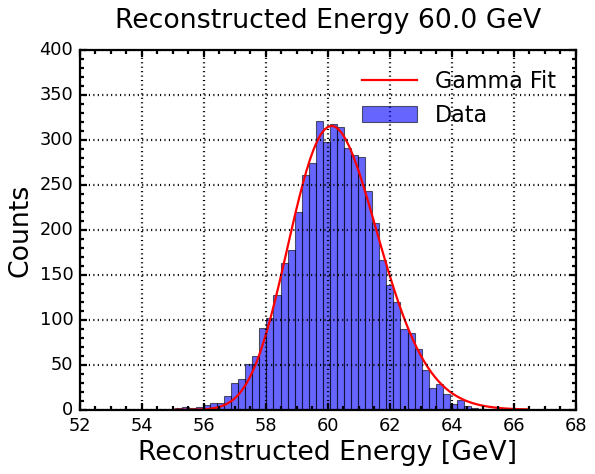

appending results for E = 60.0
Mean_Gamma: 60.36028842114841 Mean_Gamma_Error: 0.030193642057334675
Peak_Gamma: 60.11786068647393 Peak_Gamma_Error: 0.029850396381689053


In [30]:
#Fit RecoE and Save as CSV
#Gauss and LogNormal were not fitted but saved as 0 to keep format
def OutputCSV(Reco_hist, Energy_test, CSV_name):
    results = []
    for i_E in range(len(Energy_test)):
        mean_gauss,mean_gauss_error,peak_gauss, peak_gauss_error, res_gauss, res_gauss_error = 0, 0, 0, 0, 0, 0
        mean_log_normal,mean_log_normal_error,peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error = 0, 0, 0, 0, 0, 0
        mean_gamma,mean_gamma_error,peak_gamma, peak_gamma_error, res_gamma, res_gamma_error = fit_all("E_reco",Reco_hist[i_E]["E_truth"],Reco_hist[i_E]["counts"],Reco_hist[i_E]["bin_edges"])
        print("appending results for E =", Energy_test[i_E])
        print("Mean_Gamma:", mean_gamma, "Mean_Gamma_Error:", mean_gamma_error)
        print("Peak_Gamma:", peak_gamma, "Peak_Gamma_Error:", peak_gamma_error)
        results.append({
            "ParticleEnergy": Energy_test[i_E],
            "Mean_Gauss": mean_gauss,
            "Mean_Gauss_Error": mean_gauss_error,
            "Peak_Gauss": peak_gauss,
            "Peak_Gauss_Error": peak_gauss_error,
            "Res_Gauss": res_gauss,
            "Res_Gauss_Error": res_gauss_error,
            "Mean_Gamma": mean_gamma,
            "Mean_Gamma_Error": mean_gamma_error,
            "Peak_Gamma": peak_gamma,
            "Peak_Gamma_Error": peak_gamma_error,
            "Res_Gamma": res_gamma,
            "Res_Gamma_Error": res_gamma_error,
            "Mean_LogNormal": mean_log_normal,
            "Mean_LogNormal_Error": mean_log_normal_error,
            "Peak_LogNormal": peak_log_normal,
            "Peak_LogNormal_Error": peak_log_normal_error,
            "Res_LogNormal": res_log_normal,
            "Res_LogNormal_Error": res_log_normal_error
        })
    df = pd.DataFrame(results)
    df.to_csv(CSV_name, index=False)
outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP1_Fit.csv")
OutputCSV(Reco_hist_mlp_all[0], Energy_test, outputfile_name)
# for i_para, para in enumerate(ParameterScan):
#     if i_para != 0:
#         continue  # 
#     #outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP_LR{para:.0e}_Fit.csv")
#     outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP_Fit.csv")
#     OutputCSV(Reco_hist_mlp_all[i_para], Energy_test, outputfile_name)
#     print(f"Saved fit results to {outputfile_name}")

In [31]:
# X = np.vstack([X_train_scaled, X_validate_scaled])
# y_pred = mlp_model(torch.tensor(X, dtype=torch.float32).to(device)).detach().cpu().numpy()
# y_pred_calib = y_pred*(1-E_calib_fit(y_pred))
# X_train2 = np.hstack([
#     E_layers_uniform, 
#     E_layers_uniform_ratio,
#     N_layers_uniform, 
#     N_layers_uniform_ratio,
#     E_N_layers_uniform,
#     y_pred_calib[:, np.newaxis]
# ])
# X_test2 = np.hstack(
#     [E_layers_test, 
#     E_layers_test_ratio,
#     N_layers_test, 
#     N_layers_test_ratio,
#     E_N_layers_test,
#     y_pred_test_mlp_calib[:, np.newaxis]
# ])
# y_train2 = E_truth_uniform
# y_test2 = E_truth_test

# random_state = 42
# val_split = 0.2
# X_train2, X_validate2, y_train2, y_validate2 = train_test_split(X_train2, y_train2, test_size=val_split, random_state=random_state)
# scaler = StandardScaler()
# X_train_scaled2 = scaler.fit_transform(X_train2)
# X_validate_scaled2 = scaler.transform(X_validate2)

# ParameterScan=[1e-3,]#not used, but the loop is kept for future parameter scanning
# for lr in ParameterScan:
#   mlp_model2= train_mlp(X_train_scaled2, y_train2,X_validate_scaled2, y_validate2,
#                     activation=nn.PReLU(),
#                     hidden_dims=[64,32,16],
#                       dropout=0.1,
#                       # loss=HuberRelativeLoss(delta=0.1),
#                       loss=RelativeMSELoss(),
#                       lr=lr,
#                       batch_size=4096,
#                       epochs=50,
#                       patience=10,
#                       random_state=random_state)
#   device = next(mlp_model2.parameters()).device
#   torch.save(mlp_model2, DataPath_Validate+f"/Models/MLP.pth")


In [32]:

# X_validate_tensor2 = torch.tensor(X_validate_scaled2, dtype=torch.float32).to(device)
# y_pred = mlp_model2(X_validate_tensor2).detach().cpu().numpy()
# y_true = y_validate2
# X_test_scaled2 = scaler.transform(X_test2)
# X_test_tensor2 = torch.tensor(X_test_scaled2, dtype=torch.float32).to(device)
# with torch.no_grad():
#     y_pred_test_mlp = mlp_model2(X_test_tensor2).detach().cpu().numpy()
# # Reco_hist_mlp_all.clear()
# Reco_hist_mlp = build_reco_hist(y_pred_test_mlp, E_truth_test, Energy_test, Nbins=50)
# Reco_hist_mlp_all.append(Reco_hist_mlp)

# outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP2_Fit.csv")
# OutputCSV(Reco_hist_mlp_all[0], Energy_test, outputfile_name)

In [33]:
# def get_max_depth(tree):
#     if "left_child" not in tree and "right_child" not in tree:
#         return 1
#     left_depth = get_max_depth(tree["left_child"]) if "left_child" in tree else 0
#     right_depth = get_max_depth(tree["right_child"]) if "right_child" in tree else 0
#     return 1 + max(left_depth, right_depth)


# def summarize_lgbm_model(lgb_reg, top_n_features=10):
#     booster = lgb_reg.booster_
#     model_info = booster.dump_model()    
#     print("===== LightGBM Model Summary =====")
#     print("Initial Model Parameters:")
#     for k, v in lgb_reg.get_params().items():
#         print(f"  {k}: {v}")    
#     trees = model_info['tree_info']
#     num_trees = len(trees)
    
#     tree_depths = [get_max_depth(tree['tree_structure']) for tree in trees]
#     tree_leaves = [tree['num_leaves'] for tree in trees]
    
#     print("\nTrained model statistics:")
#     print(f"  Number of trees   : {num_trees}")
#     print(f"  Max tree depth    : {max(tree_depths)} (range {min(tree_depths)} - {max(tree_depths)})")
#     print(f"  Max leaves per tree : {max(tree_leaves)} (range {min(tree_leaves)} - {max(tree_leaves)})")
    
#     importance_gain = booster.feature_importance(importance_type='gain')
#     importance_idx = np.argsort(importance_gain)[::-1]
#     print(f"\nTop {top_n_features} features by gain importance:")
#     for i in range(min(top_n_features, len(importance_gain))):
#         idx = importance_idx[i]
#         print(f"  Feature {idx}: Gain {importance_gain[idx]:.3f}")

# def lightgbm_train_weighted(X_train, y_train, X_val, y_val, eps=1e-6):
#     sample_weight = (1 / (y_train + eps))**2
#     lgb_reg = lgb.LGBMRegressor(
#         objective='regression_l2',
#         n_estimators=1000,
#         learning_rate=0.001,
#         max_depth=11,
#         num_leaves=2048,
#         min_child_samples=100,
#         random_state=42
#     )

#     lgb_reg.fit(
#         X_train, y_train,
#         eval_set=[(X_train, y_train), (X_val, y_val)],
#         eval_metric='rmse',
#         sample_weight=sample_weight,
#         callbacks=[lgb.early_stopping(stopping_rounds=50)]
#     )
#     evals_result = lgb_reg.evals_result_
#     plt.figure(figsize=(8, 6))
#     plt.plot(evals_result['training']['rmse'], label='Train RMSE')
#     plt.plot(evals_result['valid_1']['rmse'], label='Validation RMSE')
#     plt.xlabel("Iteration")
#     plt.ylabel("RMSE")
#     plt.title("LightGBM Training Curve (Weighted)")
#     plt.legend()
#     plt.grid(True, linestyle='--', alpha=0.6)
#     plt.tight_layout()
#     plt.show()

#     return lgb_reg


# X = np.vstack([X_train_scaled, X_validate_scaled])
# y_pred = mlp_model(torch.tensor(X, dtype=torch.float32).to(device)).detach().cpu().numpy()
# y_pred_calib = y_pred*(1-E_calib_fit(y_pred))
# X_train2 = np.hstack([
#     E_layers_uniform, 
#     E_layers_uniform_ratio,
#     N_layers_uniform,
#     N_layers_uniform_ratio,
#     E_N_layers_uniform, 
#     y_pred_calib[:, np.newaxis],
# ])
# X_test2 = np.hstack(
#     [E_layers_test, 
#         E_layers_test_ratio,
#      N_layers_test,
#         N_layers_test_ratio,
#      E_N_layers_test, 
#      y_pred_test_mlp_calib[:,np.newaxis],
# ])
# y_train2 = E_truth_uniform
# y_test2 =  E_truth_test

# #Scaling
# random_state = 42
# val_split = 0.2
# X_train2, X_validate2, y_train2, y_validate2 = train_test_split(X_train2, y_train2, test_size=val_split, random_state=random_state)
# scaler = StandardScaler()
# X_train_scaled2 = scaler.fit_transform(X_train2)
# X_validate_scaled2 = scaler.transform(X_validate2)

# lgb_reg = lightgbm_train_weighted(X_train_scaled2, y_train2, X_validate_scaled2, y_validate2)
# y_pred_val_gbm = lgb_reg.predict(X_validate_scaled2)
# y_pred_test_gbm = lgb_reg.predict(scaler.transform(X_test2))
# summarize_lgbm_model(lgb_reg)
# del lgb_reg
# gc.collect()

# y_pred_test_gbm_calib = y_pred_test_gbm
# Reco_hist_mlp2 = build_reco_hist(y_pred_test_gbm_calib, E_truth_test, Energy_test, Nbins=50)
# Reco_hist_mlp_all.append(Reco_hist_mlp2)
# outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP1_Fit.csv")
# OutputCSV(Reco_hist_mlp_all[1], Energy_test, outputfile_name)